In [1]:
# Change current work path to root
import os
os.chdir('../')

In [2]:
import random

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import torch 

from model import Model
from network import VanillaLSTM, SeqT2v, GreedySeqT2v
from utils import sliding_window, train_test_split

In [3]:
# Set up random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Dataset

Source: https://www.kaggle.com/danofer/time2vec-water-levels/data

In [4]:
data = pd.read_csv('data/venezia.csv')

# Date Correction
data['datetime'] = pd.date_range(data.loc[0, 'datetime'], periods=data.shape[0], freq='H')

# Set level_change as target
data['level_change'] = data['level'].diff()
data = data[1:].reset_index(drop=True)

data['timestamp'] = data.index
data['datetime'] = pd.to_datetime(data['datetime'])

# Create date features
data['year'] = data['datetime'].dt.year - data['datetime'].dt.year.min()
data['monthofyear'] = data['datetime'].dt.month
data['weekofyear'] = data['datetime'].dt.isocalendar().week 
data['dayofyear'] = data['datetime'].dt.dayofyear
data['dayofmonth'] = data['datetime'].dt.day
data['dayofweek'] = data['datetime'].dt.weekday
data['hourofday'] = data['datetime'].dt.hour

# Simple LSTM Model

In [5]:
# Target = 'level_change'
# Value feature = 'level_change'
# Time feature = 'timestamp'

x1, _, x2, y = sliding_window(
    data[:12024], value_feature_cols=['level_change'], time_feature_cols=['timestamp'], 
    target_col='level_change', window_size=24
)

(train_x1, train_x2, train_y), (test_x1, test_x2, test_y) = train_test_split(
    x1, x2, y, test_size=2000, verbose=True)

Train Set Shape: [(10000, 24, 1), (10000, 1), (10000,)]
Test Set Shape: [(2000, 24, 1), (2000, 1), (2000,)]


In [6]:
# Define network & model
network_1 = VanillaLSTM(1, 8)
model_1 = Model(network_1)

# Train
model_1.train(train_x1, y=train_y)

Epoch: 0, Train Loss: 122.36625671386719, Valid Loss: 124.11358642578125
Epoch: 100, Train Loss: 5.128209590911865, Valid Loss: 6.33567476272583
Epoch: 200, Train Loss: 3.8315718173980713, Valid Loss: 4.761004447937012
Epoch: 300, Train Loss: 3.4888241291046143, Valid Loss: 4.398848533630371
Epoch: 400, Train Loss: 3.42868709564209, Valid Loss: 4.320288181304932
Epoch: 500, Train Loss: 3.446068525314331, Valid Loss: 4.331215858459473
Epoch   542: reducing learning rate of group 0 to 5.0000e-03.
Epoch: 600, Train Loss: 3.2646656036376953, Valid Loss: 4.161519527435303
Epoch: 700, Train Loss: 3.2475850582122803, Valid Loss: 4.154392719268799
Epoch: 800, Train Loss: 3.22662091255188, Valid Loss: 4.152279376983643
Epoch: 900, Train Loss: 3.2365620136260986, Valid Loss: 4.175410747528076
Epoch   965: reducing learning rate of group 0 to 2.5000e-03.
Best Train Loss: 3.1839048862457275, Best Valid Loss: 4.134948253631592


In [7]:
# Calculate Test MSE
mean_squared_error(test_y, model_1.predict(test_x1).cpu().detach().numpy())

4.827413970103833

# T2V LSTM Model

In [8]:
# Define network & model
network_2 = SeqT2v(1, 8, 1, 8)
model_2 = Model(network_2)

# Train
model_2.train(train_x1, train_x2, y=train_y)

Epoch: 0, Train Loss: 124.06657409667969, Valid Loss: 126.18671417236328
Epoch: 100, Train Loss: 6.610499858856201, Valid Loss: 7.477285385131836
Epoch: 200, Train Loss: 4.438692569732666, Valid Loss: 5.324557304382324
Epoch: 300, Train Loss: 4.057928085327148, Valid Loss: 4.983997344970703
Epoch: 400, Train Loss: 3.680717945098877, Valid Loss: 4.668201923370361
Epoch: 500, Train Loss: 3.9434704780578613, Valid Loss: 4.615987300872803
Epoch: 600, Train Loss: 3.8835792541503906, Valid Loss: 4.5635666847229
Epoch: 700, Train Loss: 3.5881030559539795, Valid Loss: 4.37605619430542
Epoch: 800, Train Loss: 3.510114908218384, Valid Loss: 4.281248092651367
Epoch: 900, Train Loss: 3.3487327098846436, Valid Loss: 4.215764045715332
Best Train Loss: 3.2877509593963623, Best Valid Loss: 4.167719841003418


In [9]:
# Calculate Test MSE
mean_squared_error(test_y, model_2.predict((test_x1, test_x2)).cpu().detach().numpy())

5.081834599943177

# D2V LSTM Model

In [10]:
# Target = 'level_change'
# Value feature = 'level_change'
# Time feature = ['year', 'monthofyear', 'weekofyear', 'dayofyear', 'dayofmonth', 'dayofweek', 'hourofday']

time_feature = ['year', 'monthofyear', 'weekofyear', 'dayofyear', 'dayofmonth', 'dayofweek', 'hourofday']
x1, _, x2, y = sliding_window(
    data[:12024], value_feature_cols=['level_change'], time_feature_cols=time_feature, 
    target_col='level_change', window_size=24
)

(train_x1, train_x2, train_y), (test_x1, test_x2, test_y) = train_test_split(
    x1, x2, y, test_size=2000, verbose=True)

Train Set Shape: [(10000, 24, 1), (10000, 7), (10000,)]
Test Set Shape: [(2000, 24, 1), (2000, 7), (2000,)]


In [11]:
# Define network & model
network_3 = GreedySeqT2v(1, 8, 1, 8, time_input_channel=7)
model_3 = Model(network_3)

# Train
model_3.train(train_x1, train_x2, y=train_y)

Epoch: 0, Train Loss: 122.22848510742188, Valid Loss: 123.96045684814453
Epoch: 100, Train Loss: 5.675349235534668, Valid Loss: 6.664942741394043
Epoch: 200, Train Loss: 4.115668773651123, Valid Loss: 5.281311988830566
Epoch: 300, Train Loss: 3.6877193450927734, Valid Loss: 4.7864274978637695
Epoch: 400, Train Loss: 3.5074872970581055, Valid Loss: 4.554052352905273
Epoch: 500, Train Loss: 3.6868631839752197, Valid Loss: 4.6777119636535645
Epoch: 600, Train Loss: 3.385859966278076, Valid Loss: 4.3891215324401855
Epoch: 700, Train Loss: 3.3334243297576904, Valid Loss: 4.2388176918029785
Epoch: 800, Train Loss: 3.5310776233673096, Valid Loss: 4.460576057434082
Epoch   834: reducing learning rate of group 0 to 5.0000e-03.
Epoch: 900, Train Loss: 3.2830207347869873, Valid Loss: 4.251204013824463
Epoch   935: reducing learning rate of group 0 to 2.5000e-03.
Best Train Loss: 3.346423864364624, Best Valid Loss: 4.214385509490967


In [12]:
# Calculate Test MSE
mean_squared_error(test_y, model_3.predict((test_x1, test_x2)).cpu().detach().numpy())

5.08601804084486

# Greedy D2V LSTM Model

In [13]:
# Embedding Train
frozen_t2v=[]

# Feed one time feature at one time
for i, col in enumerate(time_feature):
    print(f"=== Train time feature '{col}' ====")
    network_4 = GreedySeqT2v(1, 4, 1, 8, frozen_t2v)
    model_4 = Model(network_4, max_epoch=500)
    model_4.train(train_x1, train_x2[:, :i + 1], y=train_y)
    
    # Freeze T2V layer except last run
    if i < len(time_feature) - 1:
        frozen_t2v = network_4.freeze()

=== Train time feature 'year' ====
Epoch: 0, Train Loss: 124.60029602050781, Valid Loss: 126.45694732666016
Epoch: 100, Train Loss: 4.524484634399414, Valid Loss: 5.4666523933410645
Epoch: 200, Train Loss: 3.669807195663452, Valid Loss: 4.509640216827393
Epoch: 300, Train Loss: 3.5020806789398193, Valid Loss: 4.334068775177002
Epoch: 400, Train Loss: 3.5243117809295654, Valid Loss: 4.3589253425598145
Epoch   452: reducing learning rate of group 0 to 5.0000e-03.
Best Train Loss: 3.3300023078918457, Best Valid Loss: 4.209878921508789
=== Train time feature 'monthofyear' ====
Epoch: 0, Train Loss: 119.12017059326172, Valid Loss: 120.82910919189453
Epoch: 100, Train Loss: 4.468831539154053, Valid Loss: 5.555110931396484
Epoch: 200, Train Loss: 3.8076844215393066, Valid Loss: 5.072788715362549
Epoch: 300, Train Loss: 3.5160772800445557, Valid Loss: 4.6186909675598145
Epoch: 400, Train Loss: 3.450479030609131, Valid Loss: 4.466965675354004
Best Train Loss: 3.5628397464752197, Best Valid Loss

In [14]:
# Calculate Test MSE
mean_squared_error(test_y, model_4.predict((test_x1, test_x2)).cpu().detach().numpy())

4.6258711104519605

# Compare Performance

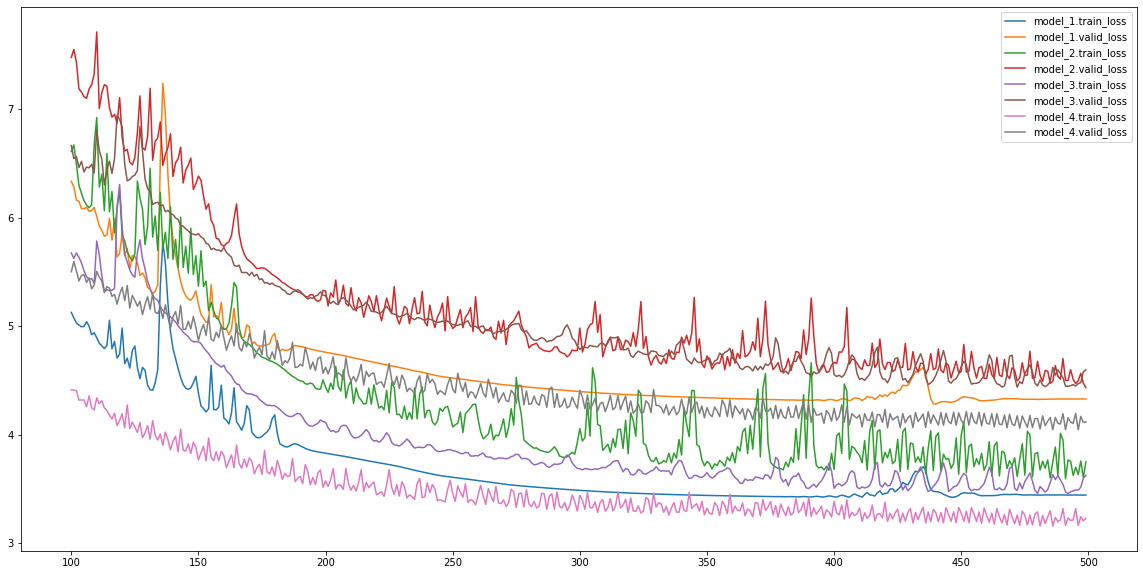

In [15]:
loss_df = pd.DataFrame(
    [model_1.train_loss, model_1.valid_loss, 
     model_2.train_loss, model_2.valid_loss, 
     model_3.train_loss, model_3.valid_loss,
     model_4.train_loss, model_4.valid_loss
    ], 
    index=['model_1.train_loss', 'model_1.valid_loss', 
           'model_2.train_loss', 'model_2.valid_loss', 
           'model_3.train_loss', 'model_3.valid_loss',
           'model_4.train_loss', 'model_4.valid_loss',
          ],
).T.iloc[100:500].plot(figsize=(20, 10))